In [1]:
%%capture
%%bash
pip install pymc3==3.8
pip install arviz==0.6.1
pip install Theano==1.0.4

mkdir data/
wget -P ./data/ https://github.com/sachinruk/bayes_school/raw/master/data/all_stocks_5yr.csv.zip 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm

%matplotlib inline

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [3]:
stocks = ['MSFT', 'AAPL', 'GOOG', 'NEM', 'ALB']
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df["Date"] = pd.to_datetime(df["Date"])
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close', 'Name']]
df_stocks = df_stocks.pivot(index='Date', columns='Name', values='Close')
# df_stocks.reset_index(inplace=True)

# df_stocks.drop("Name", axis=1, inplace=True)
df_stocks.head()

Name         AAPL    ALB    GOOG   MSFT    NEM
Date                                          
2012-08-13  90.00  61.07  329.67  30.39  46.92
2012-08-14  90.24  60.44  334.00  30.13  46.34
2012-08-15  90.12  60.87  333.44  30.20  46.63
2012-08-16  90.91  61.20  336.10  30.78  47.59
2012-08-17  92.59  61.31  338.23  30.90  47.16

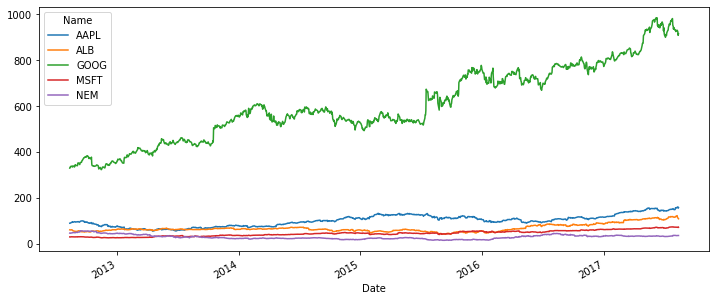

In [4]:
df_stocks.plot(figsize=(12, 5))
plt.show()

In [5]:
t = df_stocks.index.values.astype(float)
t_mean = t.mean()
t_std = t.std()
t = (t-t_mean) / t_std

y_mean = df_stocks[stocks].mean()
y_std = df_stocks.std()
y = (df_stocks[stocks] - y_mean) / y_std

t_section = df_stocks.reset_index()["Date"].dt.year.values
t_section = t_section - t_section.min()
k = t_section.max() + 1

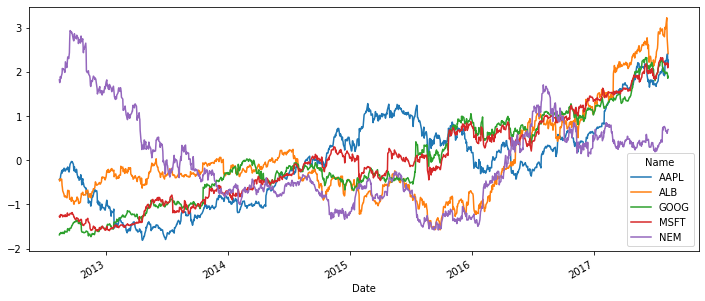

In [6]:
y.plot(figsize=(12, 5))
plt.show()

## Generating Synthetic data

[[0.68534241 0.63723771 0.37423535]
 [0.63723771 2.42926786 2.33541214]
 [0.37423535 2.33541214 3.30327538]]


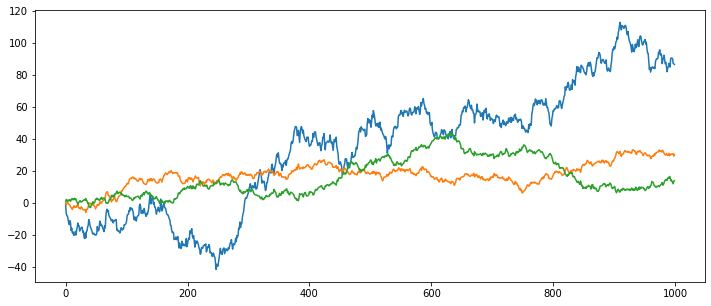

In [9]:
np.random.seed(42)

N = 1000
D = 3

Q = np.random.randn(D, D)
Σ = Q.dot(Q.T)

print(Σ)
e = np.random.randn(N, D)
e = e.dot(Q)

y2 = np.cumsum(e, axis=0)
plt.figure(figsize=(12, 5))
plt.plot(y2)
plt.show()

## Inference Process

In [10]:
def inference(y, t, t_section, k, n_samples=100):
    N, D = y.shape

    t_t = np.repeat(t[:, None], D, axis=1)
    y_t = y
    t_section_t = t_section

    with pm.Model() as model:
        # sd_β = pm.HalfCauchy.dist(beta=0.5)
        # packed_L_β = pm.LKJCholeskyCov('packed_L_β', n=D, eta=2., sd_dist=sd_β)
        # L_β = pm.expand_packed_triangular(D, packed_L_β)
        # Σ_β = pm.Deterministic('Σ_β', L_β.dot(L_β.T))

        α = pm.Normal('alpha', 0, sigma=1, shape=(k+1, D))
        # α = pm.MvGaussianRandomWalk('alpha', shape=(k+1, D), cov=Σ_α)
        β = pm.MvGaussianRandomWalk('beta', shape=(k+1, D), cov=np.eye(D))# , cov=Σ_β
        alpha_r = α[t_section_t]
        beta_r = β[t_section_t]
        regression = alpha_r+beta_r*t_t

        sd = pm.Uniform('sd', 0, 1)
        likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
        trace = pm.sample(n_samples)

    return trace

In [11]:
trace = inference(y, t, t_section, k, n_samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [01:05<00:00, 15.20it/s]


In [12]:
a_mean = trace['alpha'].mean(axis=0)
b_mean = trace['beta'].mean(axis=0)

y_pred = a_mean[t_section] + b_mean[t_section]*t[:,None]

# Un-normalise the data
y_pred_unnormalized = y_pred * y_std[None,:] + y_mean[None,:]
y_unnormalized = y * y_std[None,:] + y_mean[None,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [19]:
y_unnormalized.values

array([[ 34.86497615,  93.64060413, 329.67      ,  14.61285374,
         85.26156598],
       [ 35.10497615,  93.01060413, 334.        ,  14.35285374,
         84.68156598],
       [ 34.98497615,  93.44060413, 333.44      ,  14.42285374,
         84.97156598],
       ...,
       [105.92497615, 145.73060413, 922.9       ,  56.69285374,
         74.44156598],
       [100.18497615, 143.52060413, 907.24      ,  55.63285374,
         74.78156598],
       [102.34497615, 141.93060413, 914.39      ,  56.72285374,
         74.87156598]])

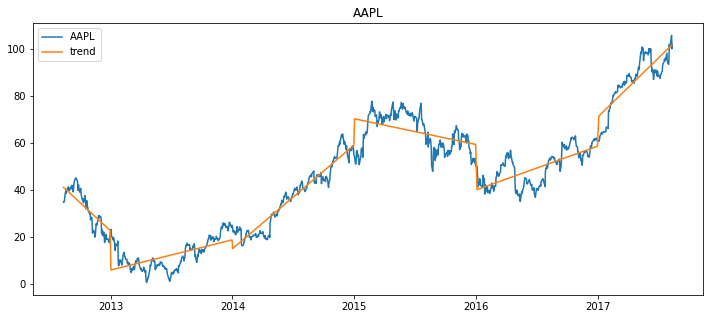

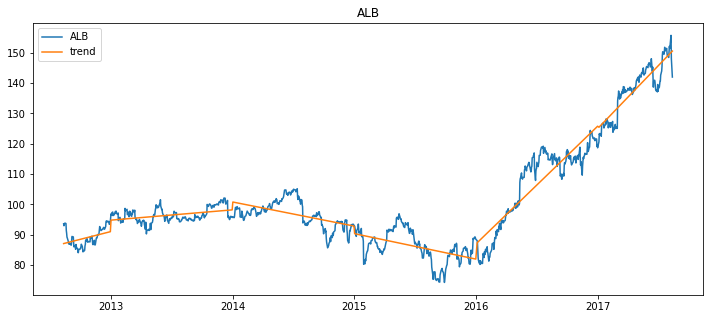

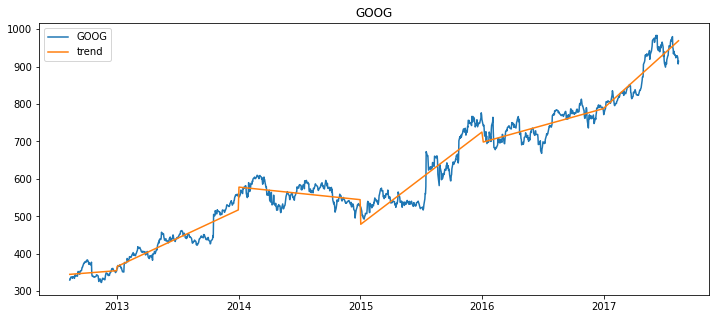

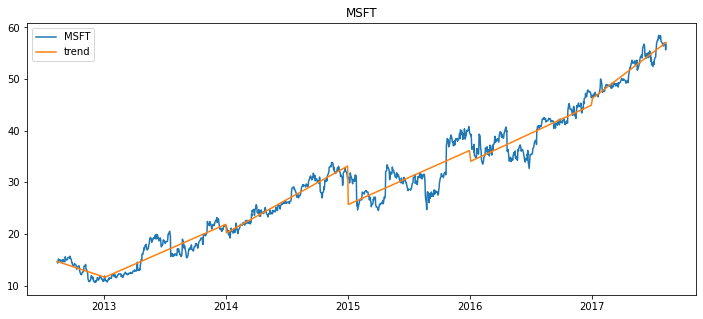

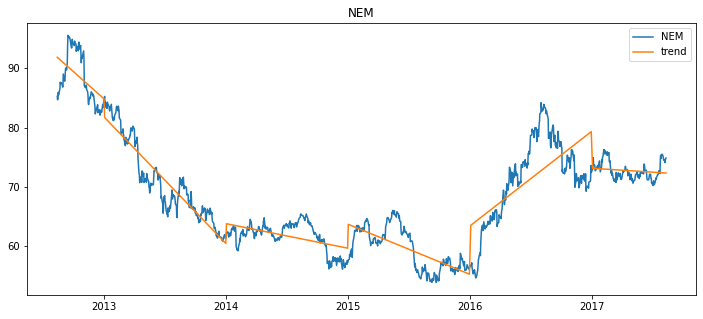

In [20]:
dates = df_stocks.index.values
stocks = df_stocks.columns.values

for i, stock in enumerate(stocks):
    plt.figure(figsize=(12,5))
    plt.plot(dates, y_unnormalized.values[:, i], label=stock)
    plt.plot(dates, y_pred_unnormalized[:, i] , label="trend")
    plt.legend()
    plt.title(stock)
    plt.show()

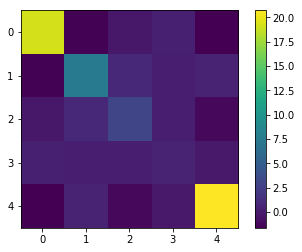

In [ ]:
plt.imshow(trace['Σ_β'].mean(axis=0))
plt.colorbar()
plt.show()

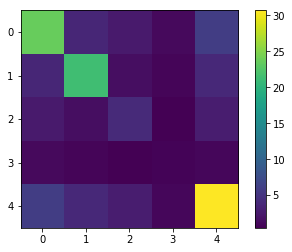

In [ ]:
plt.imshow(trace['Σ_β'].std(axis=0))
plt.colorbar()
plt.show()

## Correlation

In [ ]:
stocks

array(['AAPL', 'ALB', 'GOOG', 'MSFT', 'NEM'], dtype=object)

In [ ]:
trace_sigma2 = np.zeros_like(trace['Σ_β'])
for i,t in enumerate(trace['Σ_β']):
    t_diag = np.sqrt(t.diagonal())
    trace_sigma2[i] = (t/t_diag[:,None])/t_diag[None,:]

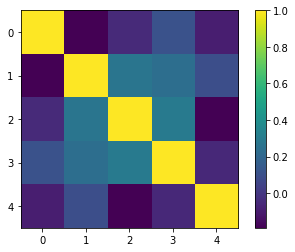

In [ ]:
plt.imshow(trace_sigma2.mean(axis=0))
plt.colorbar()
plt.show()

NEM and ALB have a correlation of 0.5 (as expected).

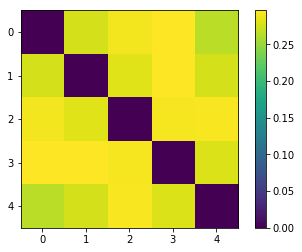

In [ ]:
plt.imshow(trace_sigma2.std(axis=0))
plt.colorbar()
plt.show()